In [1]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
provider = IBMQ.load_account()

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
# Esta funcion busca "marcar" los elementos incluidos en una lista y aplicarles un cambio de fase
def phase_oracle(n, indices_to_mark, name='Oracle'):
    qc = QuantumCircuit(n,name=name)
    # Para implementar este oraculo, utilizaremos una matrix, en lugar de un conjunto de compuertas y
    # Qiskit es capaz de encontrar una descomposicion que pueda ser implementada en hardware
    # Empezaremos creando una matriz de identidad en 2^n cubits. 
    oracle_matrix = np.identity(2**n) 
    for index_to_mark in indices_to_mark:
        # Asignamos la fase de -1 phase a los elementos marcados
        oracle_matrix[index_to_mark, index_to_mark] = -1
    # Qiskit busca convertir entonces dicha matrix en un operador unitario
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

In [3]:
# Esta funcion la denominamos "diffuser" para ser consistentes con la notacion del libro de Qiskit
# En las notas de la clase, esta funcion implementa las compuertas y oraculos dentro de la caja denominada
# "V" y consiste en las compuertas de Hadamard, el oraculo con indice f_0, seguido de las compuertas de 
# Hadamard nuevamente.
# La funcion toma como argumento el numero de cubits n y regresa el circuito implementado
def diffuser(n):
    qc = QuantumCircuit(n, name='Diff - "V"')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]), range(n)) # Aqui marcamos el indice 0
    qc.h(range(n))
    return qc

In [4]:
# Esta funcion implementa el algoritmo de Grover completo, tomando como argumento el numero de cubits
# y la lista de indices a marcar.
def Grover(n,marked):
    qc = QuantumCircuit(n,n)
    # r es el numero de veces que se aplica el bloque "V" y el oraculo y es calculado mediante la
    # expresion desarrollada en clase. Como "r" es normalmente un numero no entero, buscamos
    # el numero entero mas cerca.
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} cubits, estados base marcados: {marked}, {r} iteraciones')
    qc.h(range(n)) # Aplica la compuerta de Hadamard a todos los cubits
    for _ in range(r):
        qc.append(phase_oracle(n,marked), range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

In [5]:
# Ahora que definimos nuestro circuito de Grover, podemos implementarlo en 5 cubits
n = 5
# Utilizaremos un solo estado marcado, cuyo indice sera generado aleatoriamente
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n,marked)

qc.draw()

5 cubits, estados base marcados: [29], 4 iteraciones


┌───┐┌─────────┐┌─────────────┐┌─────────┐┌─────────────┐┌─────────┐»
q_0: ┤ H ├┤0        ├┤0            ├┤0        ├┤0            ├┤0        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_1: ┤ H ├┤1        ├┤1            ├┤1        ├┤1            ├┤1        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_2: ┤ H ├┤2 Oracle ├┤2 Diff - "V" ├┤2 Oracle ├┤2 Diff - "V" ├┤2 Oracle ├»
     ├───┤│         ││             ││         ││             ││         │»
q_3: ┤ H ├┤3        ├┤3            ├┤3        ├┤3            ├┤3        ├»
     ├───┤│         ││             ││         ││             ││         │»
q_4: ┤ H ├┤4        ├┤4            ├┤4        ├┤4            ├┤4        ├»
     └───┘└─────────┘└─────────────┘└─────────┘└─────────────┘└─────────┘»
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«     ┌─────────────┐┌─────────┐┌─────────────┐┌─┐            
«q_0: ┤0            ├┤0        ├┤0            ├┤M├────────────
«     │             ││         ││             │└╥┘┌─┐         
«q_1: ┤1            ├┤1        ├┤1            ├─╫─┤M├─────────
«     │             ││         ││             │ ║ └╥┘┌─┐      
«q_2: ┤2 Diff - "V" ├┤2 Oracle ├┤2 Diff - "V" ├─╫──╫─┤M├──────
«     │             ││         ││             │ ║  ║ └╥┘┌─┐   
«q_3: ┤3            ├┤3        ├┤3            ├─╫──╫──╫─┤M├───
«     │             ││         ││             │ ║  ║  ║ └╥┘┌─┐
«q_4: ┤4            ├┤4        ├┤4            ├─╫──╫──╫──╫─┤M├
«     └─────────────┘└─────────┘└─────────────┘ ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
«                                               0  1  2  3  4

{'10000': 1, '11010': 2, '11100': 1, '11101': 9995, '01100': 1}
3.919534679768385


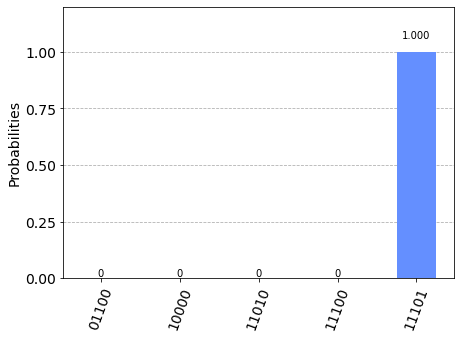

In [6]:
# Ejecutamos el circuito en el simulador
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
# Aqui imprimimos el numero de iteraciones necesarias para lograr la maxima amplificacion de amplitud
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2) 
plot_histogram(counts)

Analizando los resultados obtenidos, podemos concluir algunos puntos:
- 11101 corresponde a la representacion binaria del numero marcado 29. 
- Aqui el hecho de que el estado marcado no tenga 100% de probabilidad no es debido a ruido o efectos de decoherencia. El efecto que estamos observando es el hecho de que el agoritmo nos permite acercarnos lo mas posible al estado |w> pero no exactamente alcanzar el estado.
- De hecho, necesitamos 3.92 iteraciones de combinacion del oraculo y el bloque "V", pero nuestro algoritmo ejecuto esta secuencia 4 veces, y por lo tanto observamos algunos otros estados diferente al 11101.

## Que pasa cuando ejecutamos la secuencia Uf + V una sola vez?

5 qubits, basis state [6] marked, 4 rounds


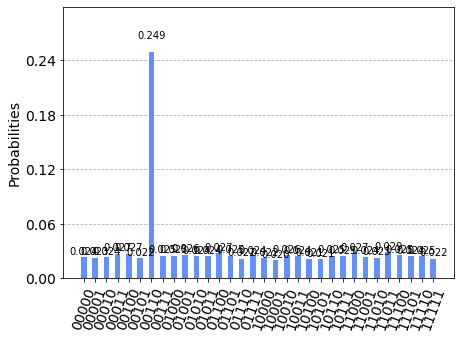

In [8]:
def Grover_run_roundwise(n,marked):
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    counts = []
    for i in range(r):
        qc = QuantumCircuit(n,n)
        qc.h(range(n))
        for _ in range(i+1):
            qc.append(phase_oracle(n,marked), range(n))
            qc.append(diffuser(n), range(n))
        qc.measure(range(n), range(n))
        result = execute(qc, backend, shots=10000).result()
        counts.append(result.get_counts(qc))
    return counts

backend = Aer.get_backend('qasm_simulator')
counts = Grover_run_roundwise(n,marked)
plot_histogram(counts[0])

{'00000': 1, '00001': 1, '10001': 1, '10011': 1, '11100': 1, '11101': 1, '00110': 9992, '01011': 1, '01100': 1}


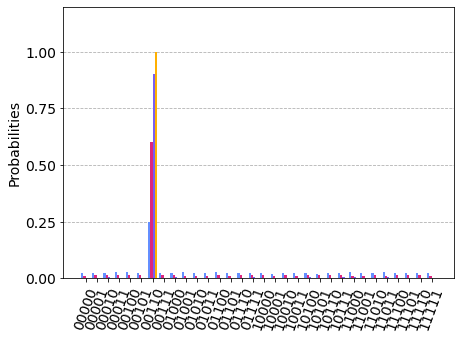

In [9]:
print(counts[3])
plot_histogram(counts, bar_labels=False)

Ahora vamos a ejecutar el algoritmo en un dispositivo cuantico!

In [12]:
n = 3 # un caso con menos cubits
# Ahora vamos a marcar dos elementos!
x = np.random.randint(2**n)
y = np.random.randint(2**n)
while y==x:
    y = np.random.randint(2**n)
marked = [x,y]
qc = Grover(n,marked)

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
%qiskit_job_watcher

shots = 1024
job = execute(qc,backend=backend, shots=shots, optimization_level=3)
print(job.job_id())

3 qubits, basis state [3, 1] marked, 1 rounds
least busy backend:  ibmq_lima


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

610177b679d0d0201d77678d


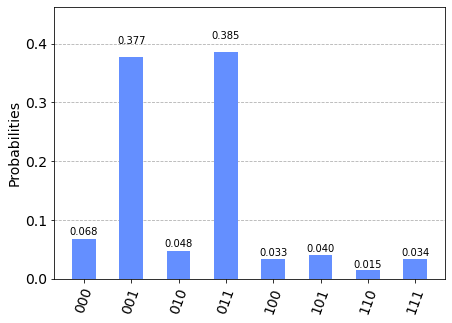

In [13]:
# Get the results
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

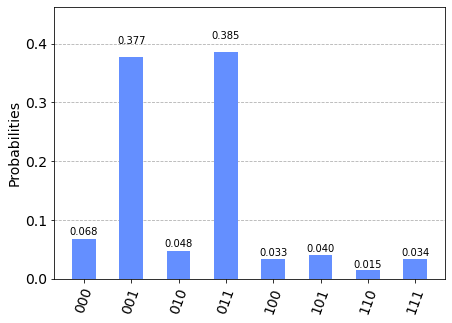

In [14]:
# Jobs I ran before
backend = provider.get_backend('ibmq_lima')
old_job = backend.retrieve_job('610177b679d0d0201d77678d')
results = old_job.result()
answer = results.get_counts()
plot_histogram(answer)